In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

%matplotlib inline

## Loading the data
We can now load the dataset into pandas using the read_csv() function. This converts the CSV file into a Pandas dataframe.

In [2]:
#Read in the csv file and convert to a Pandas dataframe
df_Football_Players = pd.read_csv("..\..\data\clean_data.csv")

In [3]:
df_Football_Players.shape

(9592, 23)

## Model




### Feature engineering: 

- Feature scaling
- Aggregation
- One hot coding

-------------------

In [4]:
df_Football_Players = df_Football_Players.drop(['name','player'],axis=1)

In [5]:
categorical_features = df_Football_Players.select_dtypes(include=object).columns
numeric_features = df_Football_Players.select_dtypes(include=np.number).columns
categorical_features

Index(['team', 'position'], dtype='object')

In [6]:
for i in categorical_features:
   print (df_Football_Players[i].value_counts())

team
Daejeon Hana Citizen      46
FC Seoul                  43
Jeonbuk Hyundai Motors    43
Daegu FC                  41
Gangwon FC                41
                          ..
Bayern Munich              6
Gaziantep FK               6
Atlético de Madrid         4
FC Barcelona               4
Real Madrid                3
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1623
Goalkeeper                    1159
Attack Centre-Forward         1145
midfield-CentralMidfield      1009
midfield-DefensiveMidfield     801
Defender Right-Back            791
Defender Left-Back             744
midfield-AttackingMidfield     674
Attack-RightWinger             630
Attack-LeftWinger              620
midfield-RightMidfield          97
midfield-LeftMidfield           93
midfield                        73
Attack                          51
Attack-SecondStriker            49
Defender                        33
Name: count, dtype: int64


In [7]:
# one hot coding for categorical_features
df_Football_Players = pd.get_dummies(df_Football_Players,columns=categorical_features)


In [8]:
df_Football_Players.head()

,Unnamed: 0,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,1,196.0,30.0,15,0.000000,0.000000,0.069018,0.0,0.0,1.242331,...,False,False,False,True,False,False,False,False,False,False
1,8,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.0,0.000000,...,True,False,False,False,False,False,False,False,False,False
2,10,169.0,23.0,89,0.012619,0.063096,0.227145,0.0,0.0,0.000000,...,False,True,False,False,False,False,False,False,False,False
3,11,180.0,22.0,34,0.000000,0.033507,0.335071,0.0,0.0,0.000000,...,False,True,False,False,False,False,False,False,False,False
4,20,181.0,20.0,39,0.129125,0.064562,0.225968,0.0,0.0,0.000000,...,False,False,False,False,False,False,True,False,False,False


In [9]:
df_Football_Players.shape

(9592, 409)

In [10]:
# Calculate the 35th and 75th percentiles of the current_value
p35 = df_Football_Players['current_value'].quantile(0.35)
p75 = df_Football_Players['current_value'].quantile(0.75)

# Function to categorize current_value
def categorize_value(value):
    if value < p35:
        return 'low value'
    elif value < p75:
        return 'Good value'
    else:
        return 'High value'

# Apply the function to create a new column
df_Football_Players['current_value_category'] = df_Football_Players['current_value'].apply(categorize_value)

df_Football_Players.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df_Football_Players['current_value_category'].value_counts())

current_value_category
Good value    4029
low value     3158
High value    2405
Name: count, dtype: int64


In [11]:
p35, p75

(400000.0, 2200000.0)

In [12]:
df_Football_Players['current_value_category']

0       Good value
1       Good value
2       High value
3       High value
4       Good value
           ...    
9587     low value
9588     low value
9589     low value
9590     low value
9591     low value
Name: current_value_category, Length: 9592, dtype: object

In [13]:
encoder = LabelEncoder()
df_Football_Players['current_value_category_encoded'] = encoder.fit_transform(df_Football_Players['current_value_category'])  

In [14]:
df_Football_Players['current_value_category_encoded'].value_counts()

current_value_category_encoded
0    4029
2    3158
1    2405
Name: count, dtype: int64

#### 3. Feature selection


In [15]:
correlation = df_Football_Players.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
Unnamed: 0                        0.210937
position_Goalkeeper               0.143520
position_midfield                 0.105393
goals conceded                    0.093105
                                    ...   
age                              -0.128170
days_injured                     -0.144245
games_injured                    -0.153077
minutes played                   -0.233125
appearance                       -0.253403
Name: current_value_category_encoded, Length: 409, dtype: float64


In [16]:
# Set the correlation threshold
threshold = 0.09  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category_encoded']) > threshold]['current_value_category_encoded'].index
selected_features

Index(['Unnamed: 0', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
       'goals conceded', 'minutes played', 'days_injured', 'games_injured',
       'award', 'highest_value', 'position_encoded', 'position_Attack',
       'position_Goalkeeper', 'position_midfield',
       'current_value_category_encoded'],
      dtype='object')

In [17]:
df_Football_Players = df_Football_Players[selected_features]
df_Football_Players.head()

,Unnamed: 0,age,appearance,goals,assists,yellow cards,goals conceded,minutes played,days_injured,games_injured,award,highest_value,position_encoded,position_Attack,position_Goalkeeper,position_midfield,current_value_category_encoded
0,1,30.0,15,0.000000,0.000000,0.069018,1.242331,1304,510,58,1,22000000,1,False,True,False,0
1,8,21.0,34,0.000000,0.000000,0.130529,0.000000,2758,47,13,0,2000000,2,False,False,False,0
2,10,23.0,89,0.012619,0.063096,0.227145,0.000000,7132,182,15,3,22000000,2,False,False,False,1
3,11,22.0,34,0.000000,0.033507,0.335071,0.000000,2686,175,28,1,12000000,2,False,False,False,1
4,20,20.0,39,0.129125,0.064562,0.225968,0.000000,2788,0,0,1,800000,3,False,False,False,0


In [18]:
df_Football_Players.shape

(9592, 17)

### Prepare train and test data


In [19]:
# Prepare data
X = df_Football_Players.drop(['current_value_category_encoded'], axis=1)
y = df_Football_Players['current_value_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=99)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
X.shape

(9592, 16)

In [21]:
y.shape

(9592,)

### Build the model

In [22]:
model = LogisticRegression()

### Train the Model

In [23]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

### Test the Model


In [24]:
# Predict and evaluate the model
y_pred_test = model.predict(X_test_scaled)

### Interpretation of the Model


In [25]:
# Each row of the model.coef_ matrix tells you how each feature affects being in the corresponding class versus any other class
coeff_df = pd.DataFrame(model.coef_[2],X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Unnamed: 0,0.280959
age,0.455422
appearance,0.348408
goals,-0.086095
assists,-0.090573
yellow cards,-0.065137
goals conceded,0.096493
minutes played,-0.877693
days_injured,-0.069253
games_injured,0.073765


In [26]:
model.coef_


array([[ 3.51175405e-02,  2.99027667e-01,  1.33620758e-01,
        -2.65915482e-02,  5.22573422e-03, -3.74788744e-02,
         1.27430583e-01, -1.04220446e-01,  1.08283571e-02,
         7.42171607e-02, -4.58865098e-03,  8.37511357e-01,
         3.37134465e-02, -1.91864737e-01, -1.27752139e-01,
        -2.29942611e-01],
       [-3.16076717e-01, -7.54449530e-01, -4.82029160e-01,
         1.12686368e-01,  8.53470606e-02,  1.02615764e-01,
        -2.23923564e-01,  9.81912984e-01,  5.84243269e-02,
        -1.47981782e-01,  1.86091952e-02,  3.14980139e+00,
         3.22361572e-02, -9.29391772e-02, -3.06325897e-03,
        -1.15225765e-01],
       [ 2.80959176e-01,  4.55421862e-01,  3.48408401e-01,
        -8.60948202e-02, -9.05727949e-02, -6.51368893e-02,
         9.64929819e-02, -8.77692538e-01, -6.92526840e-02,
         7.37646211e-02, -1.40205443e-02, -3.98731275e+00,
        -6.59496037e-02,  2.84803914e-01,  1.30815398e-01,
         3.45168376e-01]])

In [27]:
print(model.intercept_) 


[ 1.29272354  0.06049917 -1.35322271]


### Evaluating the Model

In [28]:
# our benchmark model
base_model = round(df_Football_Players['current_value_category_encoded'].value_counts()[1]/df_Football_Players.shape[0]*100, 2)
base_model

25.07

#### Accuracy

In [29]:
# Train score
y_pred_train = model.predict(X_train_scaled)
accuracy_Train = accuracy_score(y_train, y_pred_train)
print(f"Train score: {accuracy_Train}")

Train score: 0.7349146357356966


In [30]:
# Test score
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test
print(f"Test score: {accuracy_test}")

Test score: 0.7337154768108389


##### Confusion matrix


In [31]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix

array([[553,  56, 208],
       [123, 360,   1],
       [117,   6, 495]], dtype=int64)

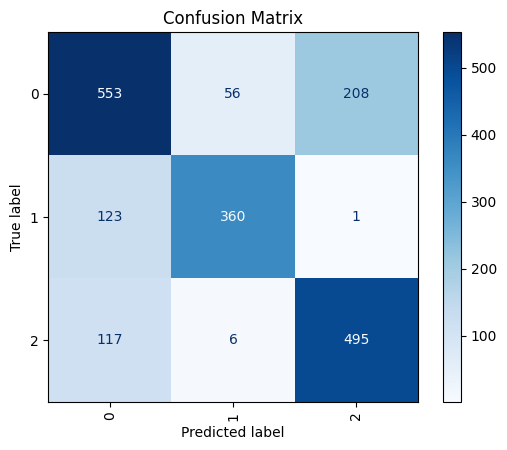

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

#### Precision

In [33]:
# Train score
precision_train = precision_score(y_train, y_pred_train, average='macro')
print(f"Precision in train: {precision_train:.2f}")

# Test score
precision_test = precision_score(y_test, y_pred_test, average='macro')
print(f"Precision in test: {precision_test:.2f}")

Precision in train: 0.76
Precision in test: 0.75


#### Recall

In [34]:
# Train score
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall in train: {recall_train:.2f}")

# Test score
recall_test = recall_score(y_test, y_pred_test, average='macro')
print(f"Recall in test: {recall_test:.2f}")

Recall in train: 0.74
Recall in test: 0.74


#### F1-Score


In [35]:
# Train score
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"f1-score in train: {f1_train:.2f}")

# Test score
f1_test = precision_score(y_test, y_pred_test, average='macro')
print(f"f1-score in test: {f1_test:.2f}")

f1-score in train: 0.74
f1-score in test: 0.75


### Classification report

In [36]:
from sklearn.metrics import classification_report

print('Train report: ')
print(classification_report(y_train, y_pred_train))

print('Test report: ')
print(classification_report(y_test, y_pred_test))

Train report: 
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      3212
           1       0.85      0.71      0.77      1921
           2       0.73      0.80      0.76      2540

    accuracy                           0.73      7673
   macro avg       0.76      0.74      0.74      7673
weighted avg       0.74      0.73      0.74      7673

Test report: 
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       817
           1       0.85      0.74      0.79       484
           2       0.70      0.80      0.75       618

    accuracy                           0.73      1919
   macro avg       0.75      0.74      0.74      1919
weighted avg       0.74      0.73      0.73      1919

